# NYC Taxi Trip Duration Challenge: Exploring other Datasets

_By [Michael Rosenberg](mailto:rosenberg.michael.m@gmail.com)._

_**Description**: Contains my exploration of datasets outside the original competition dataset._

_Last Updated: 9/9/2017 4:22 PM._

In [53]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

#helpers
sigLev = 3
percentLev = 100
alphaLev = .4
%matplotlib inline
sns.set_style("whitegrid")
pd.set_option("display.precision",sigLev)

One of the key components in [NYCTTD Challenge](https://www.kaggle.com/c/nyc-taxi-trip-duration) is the availability of other datasets to augment our analysis of our current dataset. Let's take a gander at a couple of these datasets to see if they would be welcome augments into our current dataset.

In [54]:
trainFrame = pd.read_csv("../data/raw/train.csv")
testFrame = pd.read_csv("../data/raw/test.csv")

# NYC Holidays

With the [NYC 2016 Holidays](https://www.kaggle.com/pceccon/nyc2016holidays) dataset, we can now indicate major holidays within the city. It's very possible that we will see a larger amount of traffic on these days, and thus longer trip durations on these days.

In [55]:
holidayFrame = pd.read_csv("../data/preprocessed/NYC_2016Holidays.csv",
                           sep = ";")

In [56]:
holidayFrame

,Day,Date,Holiday
0,Friday,January 01,New Years Day
1,Monday,January 18,Martin Luther King Jr. Day
2,Friday,February 12,Lincoln's Birthday
3,Monday,February 15,Presidents' Day
4,Sunday,May 08,Mother's Day
5,Monday,May 30,Memorial Day
6,Sunday,June 19,Father's Day
7,Monday,July 04,Independence Day
8,Monday,September 05,Labor Day
9,Monday,October 10,Columbus Day


_Table 1: holidays in NYC._

We see that there are 15 holidays in the NYC calendar. That being said, it's not clear that everyone gets time off on these holidays, which could suggest that these holidays are not as meaningful as we would expect. Let's take a look at the distribution of these holidays in our dataframes.

In [57]:
#get holiday day and month
def getMonth(row):
    #helper for getting month in a row of observations for the holiday frame
    monthVec = ["January","February","March","April","May","June","July",
                "August","September","October","November","December"]
    givenMonth = row["Date"].split(" ")[0]
    return(monthVec.index(givenMonth) + 1)
    
def getDay(row):
    givenDay = row["Date"].split(" ")[1]
    return(int(givenDay))
holidayFrame["month"] = [getMonth(row[1]) for row in holidayFrame.iterrows()]
holidayFrame["day"] = [getDay(row[1]) for row in holidayFrame.iterrows()]
#get training and testing days and month
trainFrame["pickup_datetime"] = pd.to_datetime(trainFrame["pickup_datetime"])
testFrame["pickup_datetime"] = pd.to_datetime(testFrame["pickup_datetime"])
trainFrame["day"] = trainFrame["pickup_datetime"].dt.day
trainFrame["month"] = trainFrame["pickup_datetime"].dt.month
testFrame["day"] = testFrame["pickup_datetime"].dt.day
testFrame["month"] = testFrame["pickup_datetime"].dt.month

In [58]:
#drop some information from holiday frame
holidayFrame = holidayFrame.drop(["Day"],axis = 1)

In [59]:
#then merge
trainFrame = trainFrame.merge(holidayFrame,on = ["day","month"],how = "left")
testFrame = testFrame.merge(holidayFrame,on = ["day","month"],how = "left")

In [60]:
#then get holiday distribution
trainFrame.loc[trainFrame.Holiday.isnull(),"Holiday"] = "No Holiday"
testFrame.loc[testFrame.Holiday.isnull(),"Holiday"] = "No Holiday"
#then get the distribution of holidays in each
trainHolidayCountFrame = trainFrame.groupby("Holiday",as_index = False)[
                                        "id"].count()
trainHolidayCountFrame = trainHolidayCountFrame.rename(columns = {"id":"count"})
testHolidayCountFrame = testFrame.groupby("Holiday",as_index = False)[
                                        "id"].count()
testHolidayCountFrame = testHolidayCountFrame.rename(columns = {"id":"count"})

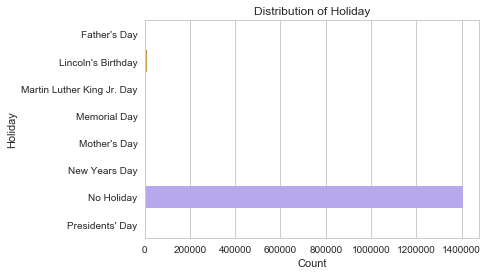

In [61]:
#then plot
sns.barplot(x = "count",y = "Holiday",data = trainHolidayCountFrame)
plt.xlabel("Count")
plt.ylabel("Holiday")
plt.title("Distribution of Holiday")

_Figure 1: Distribution of Holiday._

In [62]:
trainHolidayCountFrame["isHoliday"] = "Yes"
trainHolidayCountFrame.loc[trainHolidayCountFrame.Holiday == "No Holiday",
                           "isHoliday"] = "No"
trainHolidayCountFrame = trainHolidayCountFrame.groupby("isHoliday",
                                    as_index = False)["count"].sum()

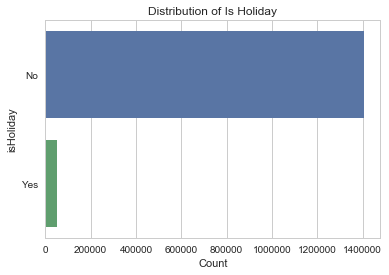

In [63]:
sns.barplot(x = "count",y = "isHoliday",data = trainHolidayCountFrame)
plt.xlabel("Count")
plt.ylabel("isHoliday")
plt.title("Distribution of Is Holiday")

_Figure 2: Distribution fo "Is Holiday"._

We see that we still have a meaningful chunk of our dataset represented in these holidays available to us. That being said, it is apparent that most of our dataset does not occur on these holidays.

Let's see how well we can predict log-Trip Duration with this "isHoliday" variable.

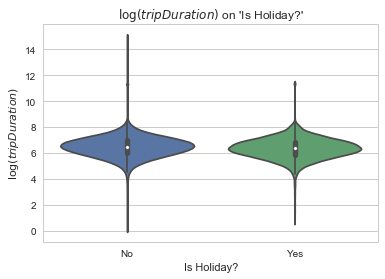

In [64]:
#generate isHoliday
trainFrame["isHoliday"] = "Yes"
trainFrame.loc[trainFrame.Holiday == "No Holiday",
               "isHoliday"] = "No"
trainFrame["logTripDuration"] = np.log(trainFrame["trip_duration"])
#then predict
sns.violinplot(x = "isHoliday",y = "logTripDuration",data = trainFrame)
plt.xlabel("Is Holiday?")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on 'Is Holiday?'")

_Figure 3: Distribution of $\log(tripDuration)$ on "Is Holiday?"._

It is apparent that we do not see major disfference between the distributions of these two plots. That being said, it looks as though the mean of $\log(tripDuration)$ looks to be slightly lower on holidays than on non-holidays. This is somewhat counter-intuitive, since we expect that demand would increase on holidays due to days off. That being said, it is also possible that taxi drivers are more likely to take the day off on a holiday, thus reducing the supply of taxis on a given Holiday.

We recognize that in the holiday dataset, there are a couple of holidays that aren't very meaningful since not many individuals outside the government get these days off. In particular, I can speak from experience that the only days that most people typically get off on are New Years, Independence Day, Labor Day, Thanksgiving, and Christmas Day. Yes, in the US, you typically don't even get Election day off, in a most  ironic fashion. Thus, let's create a "Is Meaningful Holiday?" Variable, and see if that cuts through some of the noise.

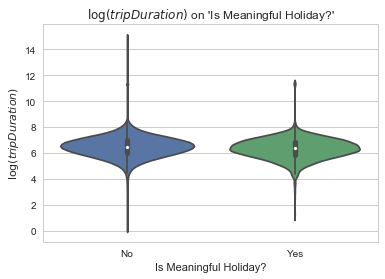

In [65]:
trainFrame["isMeaningfulHoliday"] = "No"
meaningfulHolidays = set(["New Years Day","Independence Day","Labor Day",
                          "Thanksgiving","Christmas Day (in lieu)"])
trainFrame.loc[trainFrame.Holiday.isin(meaningfulHolidays),
               "isMeaningfulHoliday"] = "Yes"
#then plot
sns.violinplot(x = "isMeaningfulHoliday",y = "logTripDuration",
               data = trainFrame)
plt.xlabel("Is Meaningful Holiday?")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on 'Is Meaningful Holiday?'")

_Figure 4: Distribution of $\log(tripDuration)$ on "Is Meaningful Holiday?"_

Again, very little change. Let's see what happens when we consider the entire dummy encoding of this variable.

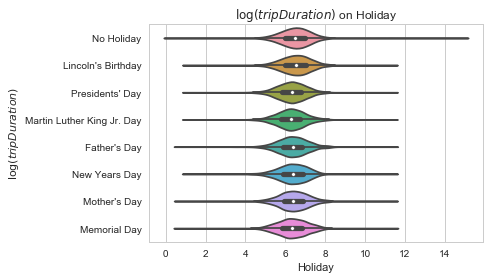

In [66]:
sns.violinplot(y = "Holiday",x = "logTripDuration",
               data = trainFrame)
plt.xlabel("Holiday")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on Holiday")

_Figure 5: Distribution of $\log(tripDuration)$ on Holiday._

We see minute differences, but at least some difference when we look at all holidays present in the dataset. Interestingly, very important holidays such as Independence Day and Christmas day look to be left out of the training set. Perhaps this is designed to throw us off for our test dataset.

# Noise Complaints

We recognize that another individual posted a dataset on [parties in NYC](https://www.kaggle.com/somesnm/partynyc), where they indicate the number of noise complaints about ongoing parties within ~500 meters and within 2 hours of pickup place and time for a given ID. Let's validate that this information attaches appropriately without any nulls to our existing dataset without any Nulls.

In [67]:
trainNoiseComplaintsFrame = pd.read_csv(
                            "../data/preprocessed/partynyc/train_parties.csv")
testNoiseComplaintFrame = pd.read_csv(
                            "../data/preprocessed/partynyc/test_parties.csv")

In [68]:
#then attach
trainFrame = trainFrame.merge(trainNoiseComplaintsFrame,on = "id",how = "left")
testFrame = testFrame.merge(testNoiseComplaintFrame,on = "id",how = "left")

In [69]:
print(trainFrame[trainFrame.num_complaints.isnull()].shape)
print(testFrame[testFrame.num_complaints.isnull()].shape)

(0, 19)
(0, 14)


It looks like we are good on that end! Now let's see what the distribution in complaints looks like.

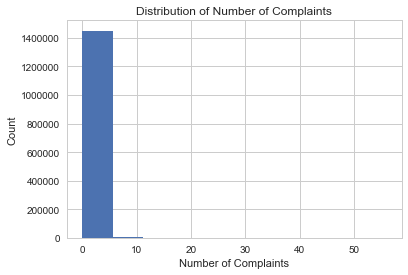

In [70]:
plt.hist(trainFrame.num_complaints)
plt.xlabel("Number of Complaints")
plt.ylabel("Count")
plt.title("Distribution of Number of Complaints")

_Figure 6: Distribution of Number of Complaints._

This is so right-skewed, it is not clear what is going on in this context. Let's see what this looks like on a log scale.

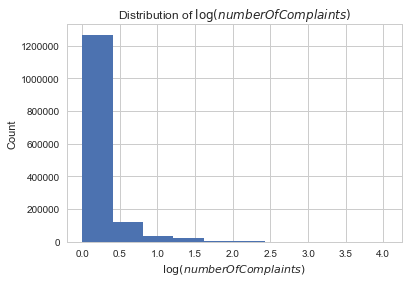

In [71]:
plt.hist(np.log(trainFrame.num_complaints+1))
plt.xlabel("$\log(numberOfComplaints)$")
plt.ylabel("Count")
plt.title("Distribution of $\log(numberOfComplaints)$")

_Figure 7: Distribution of $\log(numberOfComplaints)$._

It is apparent that we still have a relatively right-skewed distribution, with many observations sitting close to $0$ complaints.

In [72]:
trainFrame["logNumComplaints"] = np.log(trainFrame.num_complaints + 1)

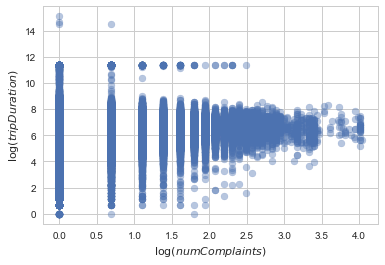

In [73]:
plt.scatter(trainFrame["logNumComplaints"],trainFrame["logTripDuration"],
            alpha = alphaLev)
plt.xlabel("$\log(numComplaints)$")
plt.ylabel("$\log(tripDuration)$")

_Figure 8: $\log(tripDuration)$ on $\log(numComplaints).$_

We notice a slight funneling effect after $e^1 \approx 3$ noise complaints. this suggests a slightly logarithmic relationship between number of complaints and trip duration at a certain point. A ReLU unit should be able to pick up on this funneling effect, so I don't see a strong reason to make an additional transformation in the time being.

# Weather Data

There were two weather datasets presented in this competition. One is the [KNYC Metars](https://www.kaggle.com/cabaki/knycmetars2016) dataset, which are the METARS aggregated weather data in 2016 for NYC, and the [Weather data in new york city 2016](https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016) dataset, which gives day-level information about weather in central park in NYC. Given that the level of granularity for the later dataset is much easier to combine with our current dataset than the former, I think it might be useful to simply consider the information in the second dataset for now.

In [74]:
weatherFrame = pd.read_csv(
                "../data/preprocessed/weather_data_nyc_centralpark_2016.csv")
#get datetime information
weatherFrame["datetime"] = pd.to_datetime(weatherFrame["date"],
                                          format = "%d-%m-%Y")
weatherFrame["day"] = weatherFrame["datetime"].dt.day
weatherFrame["month"] = weatherFrame["datetime"].dt.month
#get rid of some variables
weatherFrame = weatherFrame.drop(["date","datetime"],axis = 1)
#then attach information to training and testing
trainFrame = trainFrame.merge(weatherFrame,on = ["day","month"],how = "left")

In [76]:
testFrame = testFrame.merge(weatherFrame,on = ["day","month"],how = "left")

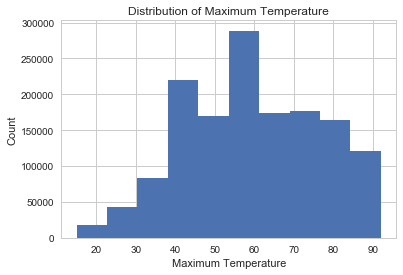

In [77]:
#then get a plot of the distribution of maximum, minimum, and average
#temperature
plt.hist(trainFrame["maximum temperature"])
plt.xlabel("Maximum Temperature")
plt.ylabel("Count")
plt.title("Distribution of Maximum Temperature")

_Figure 9: Distribution of Maximum Temperature in Central Park in 2016._

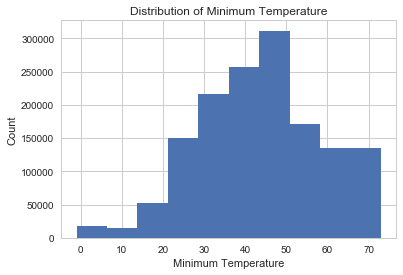

In [78]:
plt.hist(trainFrame["minimum temperature"])
plt.xlabel("Minimum Temperature")
plt.ylabel("Count")
plt.title("Distribution of Minimum Temperature")

_Figure 10: Distribution of Minimum Temperature in Central park in 2016._

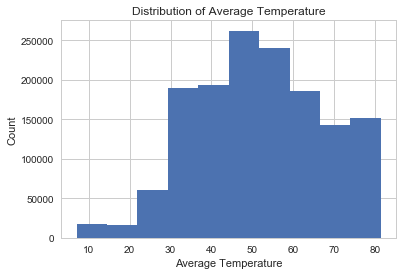

In [79]:
plt.hist(trainFrame["average temperature"])
plt.xlabel("Average Temperature")
plt.ylabel("Count")
plt.title("Distribution of Average Temperature")

_Figure 11: Distribution of Average Temperature in Central Park in 2016._

I see no serious distributional issues in Figures 9, 10, and 11. Thus, I don't yet see meaningful transformations for these variables.

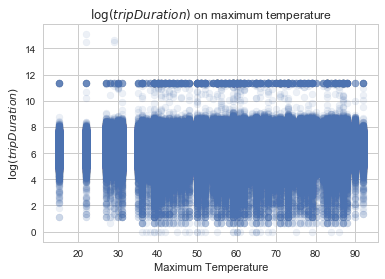

In [86]:
alphaLev = .1
plt.scatter(trainFrame["maximum temperature"],
            trainFrame["logTripDuration"],alpha = alphaLev)
plt.xlabel("Maximum Temperature")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on maximum temperature")

_Figure 12: $\log(tripDuration)$ on Maximum Temperature._

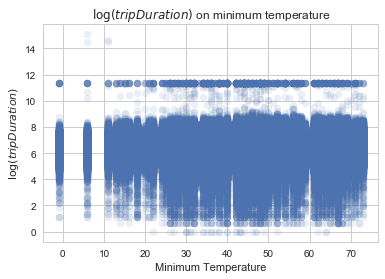

In [87]:
plt.scatter(trainFrame["minimum temperature"],
            trainFrame["logTripDuration"],alpha = alphaLev)
plt.xlabel("Minimum Temperature")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on minimum temperature")

_Figure 13: $\log(tripDuration)$ on minimum temperature._

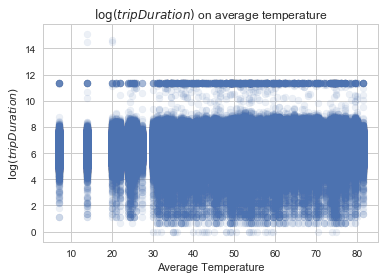

In [89]:
plt.scatter(trainFrame["average temperature"],
            trainFrame["logTripDuration"],alpha = alphaLev)
plt.xlabel("Average Temperature")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on average temperature")

_Figure 14: $\log(tripDuration)$ on average temperature._

In Figures 12, 13, and 14, there is no clear relationship forming. Thus, it seems to me that temperature is not having a very strong direct effect. That being said, it could have a strong interaction effect with our other variables.

We have two choices for our precipitation variables: Either encode a dummy for "at or above trace", or send trace to $0$. Let's try both.

## Send Trace to 0

In [97]:
trainFrame["precipitation_t0"] = trainFrame["precipitation"]
trainFrame.loc[trainFrame.precipitation == "T","precipitation_t0"] = 0
trainFrame["precipitation_t0"] = trainFrame["precipitation_t0"].astype("float")
trainFrame["snow fall_t0"] = trainFrame["snow fall"]
trainFrame.loc[trainFrame["snow fall"] == "T","snow fall_t0"] = 0
trainFrame["snow fall_t0"] = trainFrame["snow fall_t0"].astype("float")
trainFrame["snow depth_t0"] = trainFrame["snow depth"]
trainFrame.loc[trainFrame["snow depth"] == "T","snow depth_t0"] = 0
trainFrame["snow depth_t0"] = trainFrame["snow depth_t0"].astype("float")

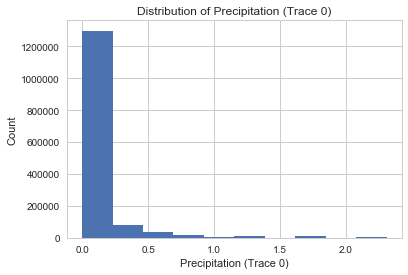

In [98]:
#then plot each
plt.hist(trainFrame["precipitation_t0"])
plt.xlabel("Precipitation (Trace 0)")
plt.ylabel("Count")
plt.title("Distribution of Precipitation (Trace 0)")

_Figure 16: Distribution of Precipitation (Trace 0)._

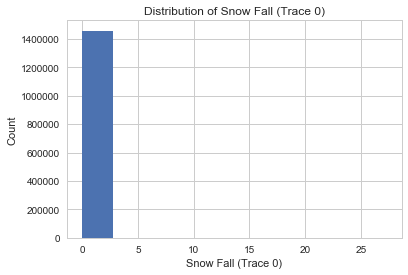

In [99]:
plt.hist(trainFrame["snow fall_t0"])
plt.xlabel("Snow Fall (Trace 0)")
plt.ylabel("Count")
plt.title("Distribution of Snow Fall (Trace 0)")

_Figure 17: Distribution of Snow Fall (Trace 0)._

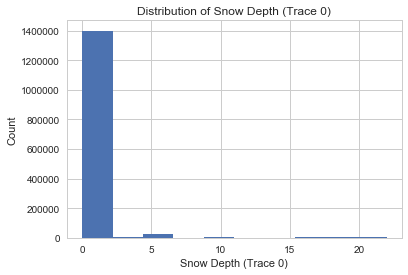

In [100]:
plt.hist(trainFrame["snow depth_t0"])
plt.xlabel("Snow Depth (Trace 0)")
plt.ylabel("Count")
plt.title("Distribution of Snow Depth (Trace 0)")

_Figure 18: Distribution of Snow Depth (trace 0)._

We see that each of these distributions have extremely right-skewed distributions. Let's log them.

In [101]:
trainFrame["logPrecipitation"] = np.log(trainFrame["precipitation_t0"] + 1)
trainFrame["logSnowFall"] = np.log(trainFrame["snow fall_t0"] + 1)
trainFrame["logSnowDepth"] = np.log(trainFrame["snow depth_t0"] + 1)

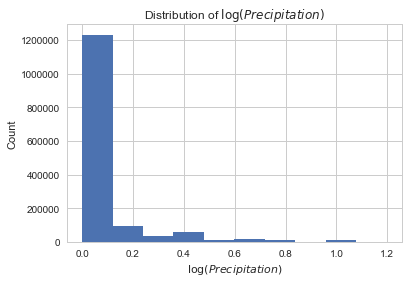

In [102]:
plt.hist(trainFrame["logPrecipitation"])
plt.xlabel("$\log(Precipitation)$")
plt.ylabel("Count")
plt.title("Distribution of $\log(Precipitation)$")

_Figure 19: Distribution of $\log(Precipitation)$._

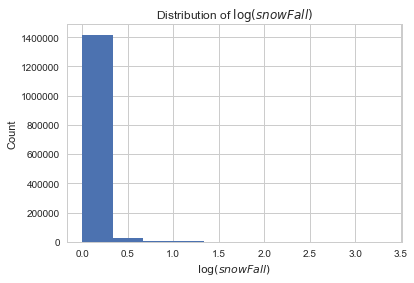

In [103]:
plt.hist(trainFrame["logSnowFall"])
plt.xlabel("$\log(snowFall)$")
plt.ylabel("Count")
plt.title("Distribution of $\log(snowFall)$")

_Figure 20: Distribution of $\log(snowFall)$._

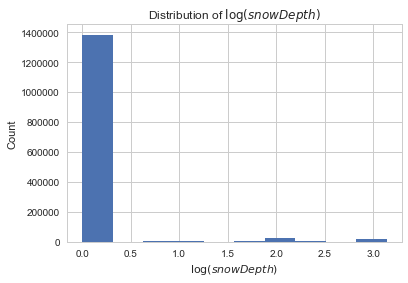

In [104]:
plt.hist(trainFrame["logSnowDepth"])
plt.xlabel("$\log(snowDepth)$")
plt.ylabel("Count")
plt.title("Distribution of $\log(snowDepth)$")

_Figure 21: Distribution of $\log(snowDepth)$._

It is apparent that while the logging slightly improves the shape of the distributions, it is clear that there is still major right-skewness to the distribution.

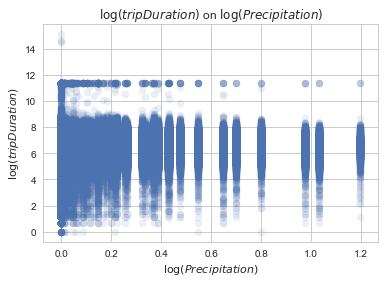

In [106]:
#plot
plt.scatter(trainFrame["logPrecipitation"],trainFrame["logTripDuration"],
            alpha = alphaLev)
plt.xlabel("$\log(Precipitation)$")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on $\log(Precipitation)$")

_Figure 22: $\log(tripDuration)$ on $\log(precipitation)$._

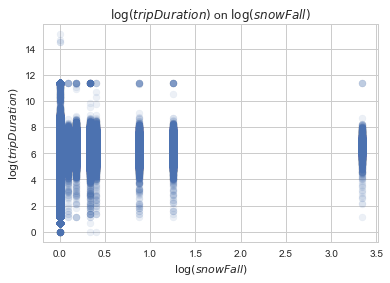

In [107]:
#plot
plt.scatter(trainFrame["logSnowFall"],trainFrame["logTripDuration"],
            alpha = alphaLev)
plt.xlabel("$\log(snowFall)$")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on $\log(snowFall)$")

_Figure 23: $\log(tripDuration)$ on $\log(snowFall)$._

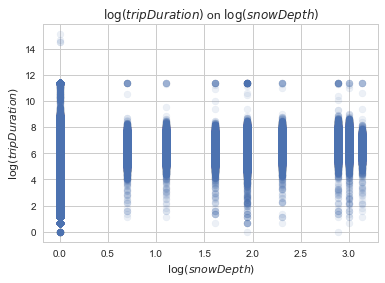

In [108]:
#plot
plt.scatter(trainFrame["logSnowDepth"],trainFrame["logTripDuration"],
            alpha = alphaLev)
plt.xlabel("$\log(snowDepth)$")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on $\log(snowDepth)$")

_Figure 24: $\log(tripDuration)$ on $\log(snowFall)$._

There is a clear funneling effect found in figures 22, 23, and 24. thus, there looks to be some signal being formed by these variables.

## Add Trace to positive dummification

Let's see what happens when we add trace to positive dummification.

In [123]:
#precipitation
trainFrame["isPrecipitation"] = 0
trainFrame.loc[(trainFrame["precipitation"] == "T"),"logPrecipitation"] = 25
trainFrame.loc[(trainFrame["logPrecipitation"] > 0),"isPrecipitation"] = 1
#snowfall
trainFrame["isSnowFall"] = 0
trainFrame.loc[(trainFrame["snow fall"] == "T"),"logSnowFall"] = 25
trainFrame.loc[(trainFrame["logSnowFall"] > 0),"isSnowFall"] = 1
#snow depth
trainFrame["isSnowDepth"] = 0
trainFrame.loc[(trainFrame["snow depth"] == "T"),"logSnowDepth"] = 25
trainFrame.loc[(trainFrame["logSnowDepth"] > 0),"isSnowDepth"] = 1

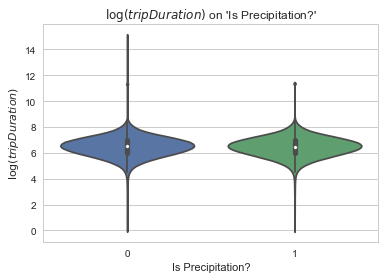

In [126]:
#then plot
sns.violinplot(x = "isPrecipitation",y = "logTripDuration",data = trainFrame)
plt.xlabel("Is Precipitation?")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on 'Is Precipitation?'")

_Figure 25: $\log(tripDuration)$ on "Is Precipitation?"._

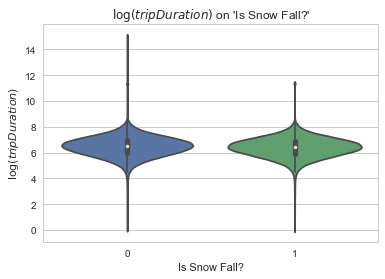

In [124]:
sns.violinplot(x = "isSnowFall",y = "logTripDuration",data = trainFrame)
plt.xlabel("Is Snow Fall?")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on 'Is Snow Fall?'")

_Figure 26: $\log(tripDuration)$ on "Is Snow Fall?"._

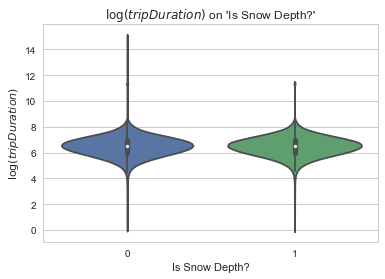

In [125]:
sns.violinplot(x = "isSnowDepth",y = "logTripDuration",data = trainFrame)
plt.xlabel("Is Snow Depth?")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on 'Is Snow Depth?'")

_Figure 27: $\log(tripDuration)$ on "Is Snow Depth?"._

## Add trace to negative dummification

In [127]:
#precipitation
trainFrame["isPrecipitation"] = 0
trainFrame.loc[(trainFrame["precipitation"] == "T"),"logPrecipitation"] = 0
trainFrame.loc[(trainFrame["logPrecipitation"] > 0),"isPrecipitation"] = 1
#snowfall
trainFrame["isSnowFall"] = 0
trainFrame.loc[(trainFrame["snow fall"] == "T"),"logSnowFall"] = 0
trainFrame.loc[(trainFrame["logSnowFall"] > 0),"isSnowFall"] = 1
#snow depth
trainFrame["isSnowDepth"] = 0
trainFrame.loc[(trainFrame["snow depth"] == "T"),"logSnowDepth"] = 0
trainFrame.loc[(trainFrame["logSnowDepth"] > 0),"isSnowDepth"] = 1

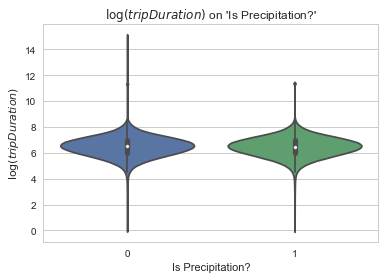

In [128]:
#then plot
sns.violinplot(x = "isPrecipitation",y = "logTripDuration",data = trainFrame)
plt.xlabel("Is Precipitation?")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on 'Is Precipitation?'")

_Figure 28: $\log(tripDuration)$ on "Is Precipitation?"._

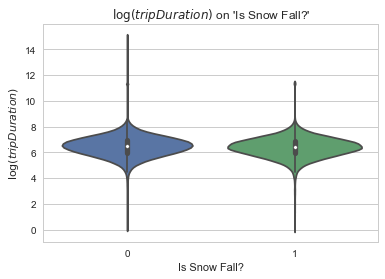

In [129]:
sns.violinplot(x = "isSnowFall",y = "logTripDuration",data = trainFrame)
plt.xlabel("Is Snow Fall?")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on 'Is Snow Fall?'")

_Figure 29: $\log(tripDuration)$ on "Is Snow Fall?"._

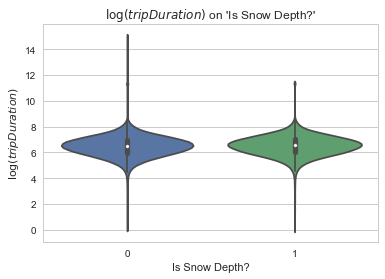

In [130]:
sns.violinplot(x = "isSnowDepth",y = "logTripDuration",data = trainFrame)
plt.xlabel("Is Snow Depth?")
plt.ylabel("$\log(tripDuration)$")
plt.title("$\log(tripDuration)$ on 'Is Snow Depth?'")

_Figure 30: $\log(tripDuration)$ on "Is Snow Depth?"._

We see in both cases a minimal difference in effect. I would say keeping this as a logged continuous variable might be our best bet, with leaving trace at $0$.

# OSRM Data

# Fix

* Try OSRM Data.

<1458644x2 sparse matrix of type '<type 'numpy.float64'>'
	with 1533440 stored elements in Compressed Sparse Column format>